In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy 
import os
import re
from collections import OrderedDict
import itertools

In [2]:
dm_identifier = {
                'mnist': 'MNIST', 
                'cifar10': 'CIFAR-10', 
                'twenty_newsgroups': '20 Newsgroups',
                'tiny_imagenet': 'Tiny-ImageNet'
                }

directory_path_to_read = "../outputs/final_results/final_results_to_tex_table"

# Calibration method identifers
cms_ = OrderedDict({'None': 'Softmax',
                    'temp_scaling': 'TS',
                    'dirichlet': 'Dirichlet',
                    'scaling_binning': 'SB',
                    'histogram_binning_top_label': 'Top-HB',
                    'auto_label_opt_v0': 'Ours'
                    })
# Train-time method identifiers
ttms_ = OrderedDict({'std_cross_entropy': 'Vanilla',
                     'crl': 'CRL', 
                     'fmfp': 'FMFP', 
                     'squentropy': 'Squentropy'})

In [3]:
# This function traverses a directory and reads all xlsx files into dataframe
def helper_find_files_and_read_dataframe(root_path, patterns=[r"cifar10"]):
    dm_df= OrderedDict((dm, None) for dm in dm_identifier.keys()) 
    for root, _, files in os.walk(root_path):
        for filename in files:
            filepath = os.path.join(root, filename)
            if os.path.isfile(filepath) and filepath.endswith(".xlsx"):
                for pattern in patterns:
                    if re.search(pattern, filename, re.IGNORECASE):
                        if pattern in dm_df:
                            dm_df[pattern] = pd.concat([dm_df[pattern], pd.read_excel(filepath, sheet_name=0).drop(columns=['Unnamed: 0'])], axis=0)
                        else:
                            dm_df[pattern] = pd.read_excel(filepath, sheet_name=0).drop(columns=['Unnamed: 0']).copy(deep=True)
                        break 
    return dm_df 

# This function filters the dataframes that are stored
def read_and_get_filtered_dataframes(root_path, patterns=[r"cifar10"]):
    dm_df = helper_find_files_and_read_dataframe(root_path, patterns = patterns)
    # Apply filter to all dataframes
    for dm, df in dm_df.items():
        if df is None:
            continue
        df1 = copy.copy(df) # Shallow copy to new dataframe
        df1['calib_conf'] = df1['calib_conf'].fillna("None")
        df1['calib_conf'] = df1['calib_conf'].astype(str)
        # Sort by col: Coverage-Mean in descending order, and then by col: calib_conf in ascending order
        df2 = df1.sort_values(["Coverage-Mean", "calib_conf"], ascending = [False, True]).copy(deep=True)
        # Retain the first row for each unique value in col: calib_conf
        df3 = df2.drop_duplicates(subset=['calib_conf', 'training_conf'], keep='first').copy(deep=True)
        dm_df[dm] = df3
    return dm_df 

In [4]:
dm_df = read_and_get_filtered_dataframes( root_path = f"{directory_path_to_read}", patterns = dm_identifier.keys())

In [5]:
dm_df['mnist'].head()

,calib_conf,training_conf,C_1,N_t,N_v,N_hyp_v,Auto-Labeling-Err-Mean,Coverage-Mean,Avg-ECE-Val-Mean,Auto-Labeling-Err-Std,...,training_conf.optimizer,training_conf.reg,training_conf.weight_decay,training_conf_g.batch_size,training_conf_g.max_epochs,training_conf_g.optimizer,training_conf_g.weight_decay,weight_decay,rank_target,rank_weight
1,auto_label_opt_v0,squentropy,0.25,500,500,500,4.0683,97.2000,80.2390,0.7505,...,NaN,NaN,NaN,64.0,500.0,adam,1.0,0.001,NaN,NaN
0,auto_label_opt_v0,std_cross_entropy,0.25,500,500,500,4.3838,96.9396,77.3820,1.0148,...,NaN,NaN,NaN,64.0,500.0,adam,1.0,0.010,NaN,NaN
3,histogram_binning_top_label,squentropy,0.25,500,500,500,5.2956,96.3758,15.1037,0.4431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN
2,dirichlet,squentropy,0.25,500,500,500,6.7333,95.9698,14.6366,1.6107,...,NaN,0.01,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN
1,temp_scaling,std_cross_entropy,0.25,500,500,500,6.8583,95.7729,7.5169,0.5943,...,adam,NaN,0.01,NaN,NaN,NaN,NaN,0.010,NaN,NaN


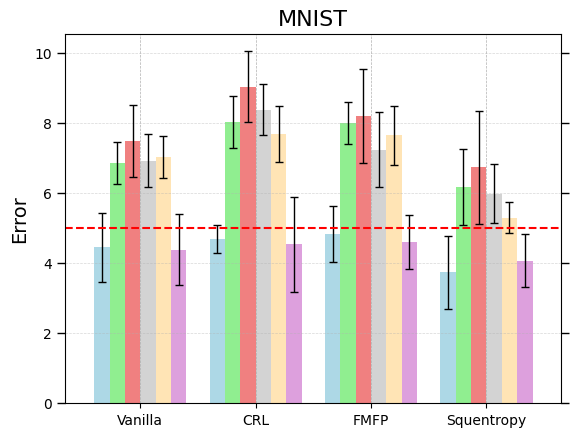

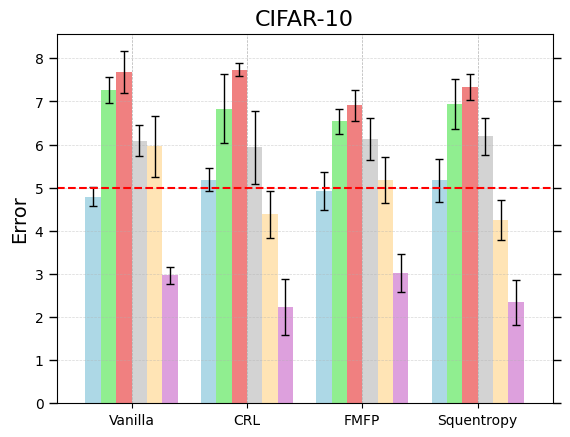

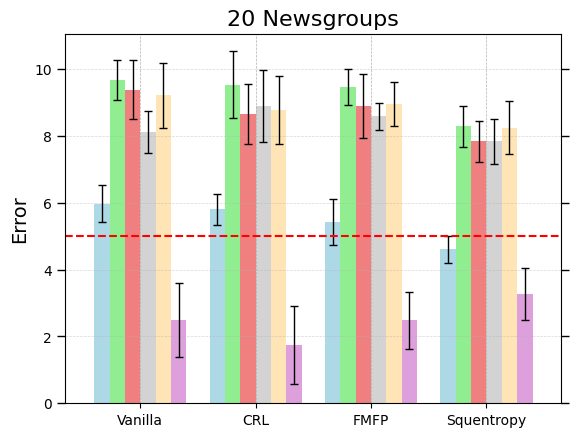

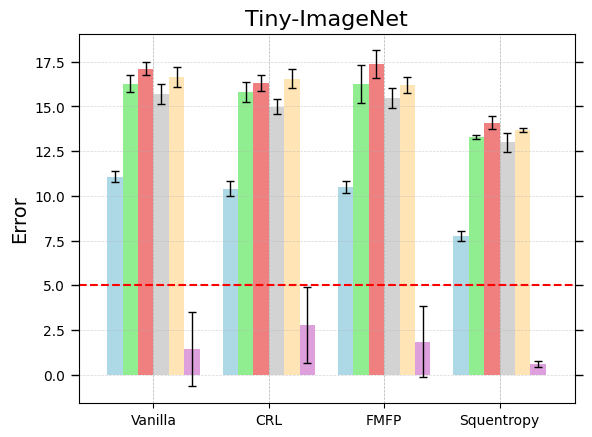

In [6]:
# ERROR
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgrey', 'moccasin', 'plum'] # colors: https://matplotlib.org/stable/gallery/color/named_colors.html
for dm, df in dm_df.items():
    d_mean = {cms_[cm]: [] for cm in cms_.keys()}
    d_std = {cms_[cm]: [] for cm in cms_.keys()}

    # Populate the dictionaries
    for tm in ttms_.keys():
        for cm in cms_.keys():
            mean_val = df[(df['training_conf'] == tm) & (df['calib_conf'] == cm)]['Auto-Labeling-Err-Mean'].values[0]
            std_val = df[(df['training_conf'] == tm) & (df['calib_conf'] == cm)]['Auto-Labeling-Err-Std'].values[0]

            d_mean[cms_[cm]].append(mean_val)
            d_std[cms_[cm]].append(std_val)
    temp_df_mean = pd.DataFrame(d_mean, index = ttms_.values())
    temp_df_err = pd.DataFrame(d_std, index = ttms_.values())
    ax = temp_df_mean.plot.bar(rot=0, yerr = temp_df_err, 
                               width = 0.8,
                               color = colors, 
                               error_kw={'ecolor':'black', 'elinewidth':1, 'capthick':1, 'capsize':3}) # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

    ax.axhline(y=5, color='r', linestyle='--')
    ax.set_title(f"{dm_identifier[dm]}", fontsize=16)
    ax.set_ylabel("Error", fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', length=6, width=1, colors='black',
               grid_alpha=0.5, left=True, right=True, labelleft=True, labelright=False)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    leg = plt.legend(prop={'size': 8}, bbox_to_anchor=(1, 0.5))  # Adjust 'size' as needed
    leg.set_visible(False)
    plt.savefig(f"./final_plots/{dm}_error.png", bbox_inches='tight')


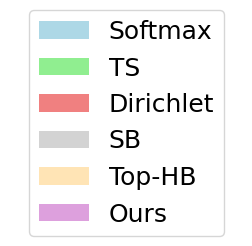

In [7]:
# Extract handles and labels for the plot's legend
handles, labels = ax.get_legend_handles_labels()

# Create a new figure for the legend
fig_leg = plt.figure(figsize=(3, 2))  # Adjust the size as needed
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')  # Hide the axes
fig_leg.legend(handles, labels, loc='center', prop={'size': 18})
plt.savefig(f"./final_plots/final_plot_legend.png", bbox_inches='tight')

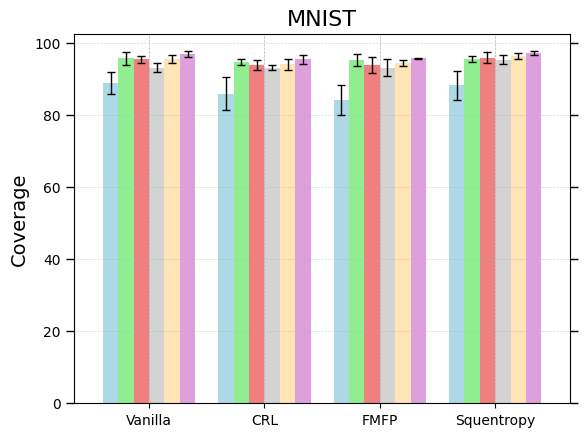

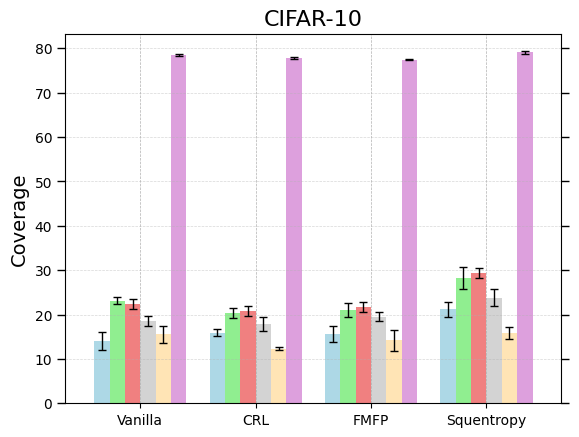

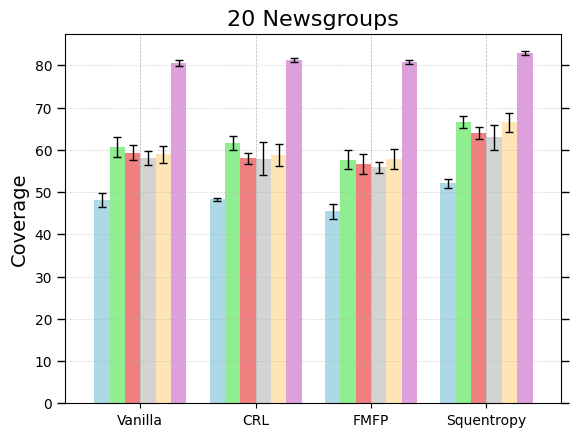

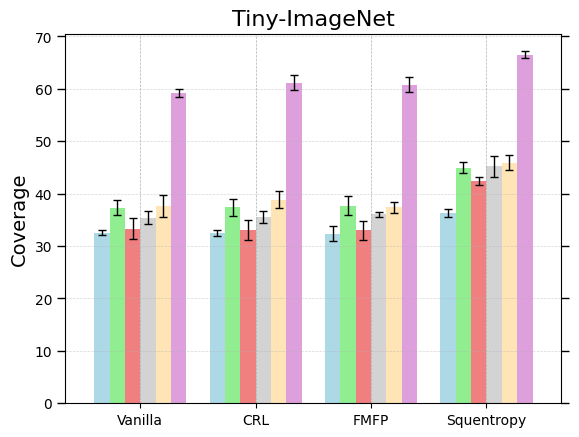

In [8]:
# COVERAGE 
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgrey', 'moccasin', 'plum']
for dm, df in dm_df.items():
    d_mean = {cms_[cm]: [] for cm in cms_.keys()}
    d_std = {cms_[cm]: [] for cm in cms_.keys()}

    # Populate the dictionaries
    for tm in ttms_.keys():
        for cm in cms_.keys():
            mean_val = df[(df['training_conf'] == tm) & (df['calib_conf'] == cm)]['Coverage-Mean'].values[0]
            std_val = df[(df['training_conf'] == tm) & (df['calib_conf'] == cm)]['Coverage-Std'].values[0]  # Assuming this column exists

            d_mean[cms_[cm]].append(mean_val)
            d_std[cms_[cm]].append(std_val)
    temp_df_mean = pd.DataFrame(d_mean, index = ttms_.values())
    temp_df_err = pd.DataFrame(d_std, index = ttms_.values())
    ax = temp_df_mean.plot.bar(rot=0, 
                               yerr = temp_df_err, 
                               width = 0.8,
                               color = colors, 
                               error_kw={'ecolor':'black', 'elinewidth':1, 'capthick':1, 'capsize':3})

    ax.set_title(f"{dm_identifier[dm]}", fontsize=16)
    ax.set_ylabel("Coverage", fontsize=14)
    # ax.set_ylim([0, 100])
    ax.tick_params(axis='x', rotation=0)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='y', length=6, width=1, colors='black',
               grid_alpha=0.5, left=True, right=True, labelleft=True, labelright=False)
    leg = plt.legend(prop={'size': 8}, bbox_to_anchor=(1, 0.5))  # Adjust 'size' as needed
    leg.set_visible(False)
    plt.savefig(f"./final_plots/{dm}_coverage.png", bbox_inches='tight')
